# Insurance

In the following I will present some analysis I did on a data set about insurance charges. The goal will be to use the data to best predict charges people will be likely to see from their insurance, based on some information about the person. 

I will start by importing some useful libraries for analysis:


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Next I will read the data file and take a look at the first few lines of data to see what kind of data we have:

In [26]:
# load the data
df=pd.read_csv('insurance.csv')

In [27]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We see we have some information about different patients including:

**sex** - Insurance contractor gender, female, male

**bmi** - Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

**children** - Number of children covered by health insurance / Number of dependents

**smoker** - Smoking

**region** - The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

We also have our target data:

**charges** - Individual medical costs billed by health insurance


## Intial analysis
I'll start by taking a look at how the charges depend on the continuous variables, **age** and **bmi**. These are reasonable parameters for insurance cost, since the increases of both are associated with a higher chance of health problems. We can see in Figure 1.(b) the charges seem to follow three different linear dependencies on **age**. It is reasonable to consider that there might be three different groups to which patients belong, each well explainable by a linear regression. Figure 1.(a) shows that **bmi** might be a little less informative, though there is a sharp cut off at **bmi**=30 for charges above a certain value.

The next reasonable step is to add a hue to these plots based on some of our categorical data, such as whether the patient smokes, their gender, region etc. As we might of guessed, the most clear separation by these categories comes from knowing if the patient smokes, as this parameter has the most direct effect on health risk.
 Figure 2. shows a similar plot to Figure 1. but with the hue set for **smoker**.
 
 Figure 2. shows that whether someone smokes is a key data point. In figure 2. (b) we see that the top most group is completely made of smokers, and the bottom most group is completely made of non-smokers. Furthermore, figure 2. (a) indicates that the jump in clustered data at **bmi**=30 separates the smokers in group 2 from group 3.


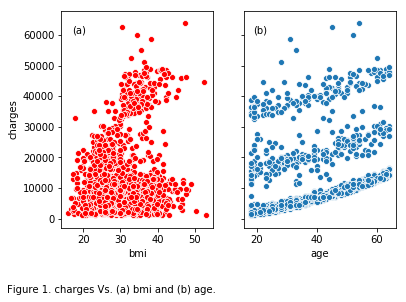

In [28]:
# set up a figure object for Figure 1
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)#fig, axes = plt.subplots(nrows=1, ncols=2)

# Make a plot of charges versus age and bmi using seaborn 
sns.scatterplot(data=df,x='bmi',y='charges',hue=None,ax=ax1,color='red')
sns.scatterplot(data=df,x='age',y='charges',hue=None,ax=ax2)

# add a caption and plot indicators
txt_fig='Figure 1. charges Vs. (a) bmi and (b) age.  ';
fig.text(0,-.1,txt_fig);
fig.text(.15,.8,'(a)');
fig.text(.57,.8,'(b)');


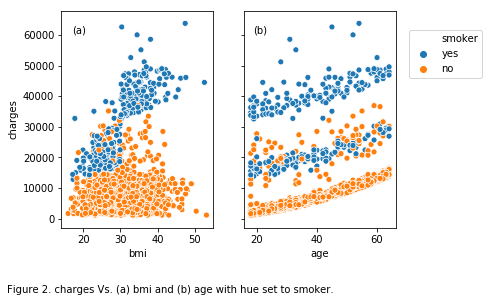

In [29]:
# set up a figure object for Figure 2
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)#fig, axes = plt.subplots(nrows=1, ncols=2)

# Make a plot of charges versus age and bmi using seaborn, 
# with hue set to smoker/non-smoker and a legend to define keys 
sns.scatterplot(data=df,x='bmi',y='charges',hue='smoker',ax=ax1,legend=False)
s=sns.scatterplot(data=df,x='age',y='charges',hue='smoker',ax=ax2)
s.legend(loc='center right', bbox_to_anchor=(1.6, .8), ncol=1,edgecolor=None)

# add a caption and plot indicators
txt_fig='Figure 2. charges Vs. (a) bmi and (b) age with hue set to smoker.  '
fig.text(0,-.1,txt_fig);
fig.text(.15,.8,'(a)');
fig.text(.57,.8,'(b)');

In figure 3. we highlight our analysis so far. We can reasonably separate three main groups: 
1. Smokers with bmi over 30
2. Smokers with bmi under 30 
3. Non-smokers.

This separation seems to explain the charges to smokers fairly well and we suspect a linear regression for the **smoker** group is the best way forward. We are left with a fair amount of non-smokers who seem to have similar charges to the smokers with **bmi** under 30, more on this group later. 

Somthing to note about the **non-smoker** group is that having a bmi over or under 30 does not seem to account for any of the behavior of their charges. For this and other reason that will become clear as we go on, I will split our data into two groups, **smoker** and **non-smoker**, when feeding data to the machine learning algorithms. The **bmi** dependencies highlight why this is a good idea. If we feed all the data to one linear regression algorithm, the clear linear dependence that the **smoker** group has on our **bmi_over30** parameter will be distorted by the random effect and in fact independence of the **non-smoker** group on this parameter.



In [30]:
# A function that assigns a value of 1/0 to patients with
# bmi over/under a value n, n is default set to 30.
def overn(bmi,n=30):
    if bmi>n:
        return 'yes'
    else:
        return 'no'
# create new numerical column indicatting a pateitn 
# as having a bmi over or under 30 
df['bmi_over30']=df['bmi'].apply(lambda x: overn(x,30))

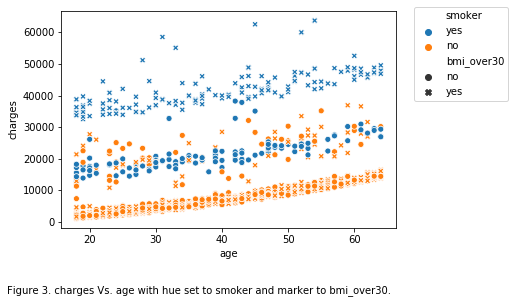

In [31]:
# set up a figure object for Figure 3
fig, ax = plt.subplots(ncols=1)

# Make a plot of charges versus age using seaborn, 
# with hue set to smoker/non-smoker, marker set to bmi being over 30
# and a legend to define keys
cVage=sns.scatterplot(data=df ,x='age',y='charges',hue='smoker',style='bmi_over30',ax=ax)
cVage.legend(loc='center right', bbox_to_anchor=(1.35, .8), ncol=1,edgecolor=None)

# add a caption and plot indicators
txt_fig='Figure 3. charges Vs. age with hue set to smoker and marker to bmi_over30.  '
fig.text(0,-.1,txt_fig);

## Machine Learning on Smoker Group
### Preparing Data
Turning our focus to the **smoker** group, I start by converting the string 'yes'/'no' of the **bmi_over30** column to an integer 1/0 column to be able to feed it to our machine learning algorithm. We already preformed this step above, but I am repeating it here to highlight the significance of creating a numerical column for a categorical feature when preparing data for machine learning algorithms. This is done because the algorithms used work best with numerical data. 

After that I create a new data frame with just the data from the **smoker** group.

In [32]:
# A function that assigns a value of 1/0 to patients with
# bmi over/under a value n, n is default set to 30.
def overn(bmi,n=30):
    if bmi>n:
        return 1
    else:
        return 0
# Create new numerical column indicating a patient 
# as having a bmi over or under 30 
df['bmi_over30']=df['bmi'].apply(lambda x: overn(x,30))

In [33]:
#A new data frame with just the data from the smokers.
dfn_smoker=df[df['smoker']=='yes'].drop('smoker',axis=1)

### Train, Test and Evaluate
We are now ready to start using some machine learning. To do this I will import a few libraries. The train_test_split library to create a training set and a test set of data for the algorithm. The Linear regression library for a machine learning model to fit our data. Lastly, the metrics library to evaluate our predictions

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Figure 4. shows how well our predictions matched our test set. The mean absolute error is MAE=2557 and the root mean squared error is RMSE=4474. RMSE is more sensitive to outliers and may be significantly larger than MAE in this instance because we have a few large outlier points and our data set is relatively small. Thus, these points are not so easily drowned out as noise.

MAE: 2557.0
RMSE: 4474.0


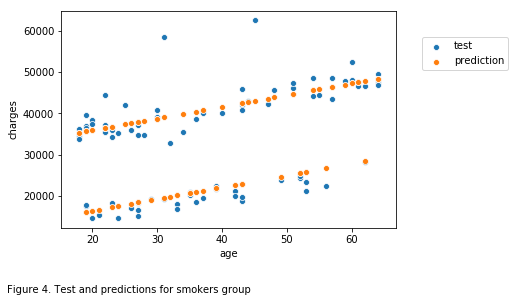

In [35]:
# Create a data frame of features, X_s, and target values, Y_s, 
# for smoker data.
# Split these into a set of traing data and a set of test data.
X_s=dfn_smoker[['age', 'bmi_over30']]
y_s=dfn_smoker['charges']
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.3, random_state=42)

# Create an instance of a linear regression model,
# train it on our training data 
# and create predictions for test data
lm_s=LinearRegression()
lm_s.fit(X_s_train,y_s_train)
pred_s=lm_s.predict(X_s_test)

# set up a figure object for Figure 4
fig, ax = plt.subplots(ncols=1)

# Make a plot of charges versus age using seaborn, 
# with both test data target values (test) and
# and predictions based on test feature data (prediction).
# Add a legend to define keys
sns.scatterplot(X_s_test['age'],y_s_test,ax=ax,label='test')
sns.scatterplot(X_s_test['age'],pred_s,ax=ax,label='prediction')
ax.legend(loc=1, bbox_to_anchor=(1.35, .9))

# Add a caption
txt_fig='Figure 4. Test and predictions for smokers group  '
fig.text(0,-.1,txt_fig);

# Use metrics to evaluate accuracy of predictions
MAE=metrics.mean_absolute_error(y_s_test,pred_s)
MSE=metrics.mean_squared_error(y_s_test,pred_s)
RMSE=np.sqrt(metrics.mean_squared_error(y_s_test,pred_s))
print('MAE: '+str(round(MAE))+'\nRMSE: '+str(round(RMSE)))

## Further Analysis on Non-Smoker Group

Turning to the **non-smoker** group, we again note that there seems to be two groups, one with a wide variance around the area that was constituted by the smokers with **bmi** under 30, and the other that seems to follow some fixed behavior. A dashed line is drawn to separate these groups. 

We see an interesting effect on the lower group when setting the hue to the number of children of the contractor and the marker used based on the sex of the contractor. It seems that a larger number of children will raise the charges, and that for each age women will be charged more than men. This makes sense since more children means more health coverage, and women will be more likely to incur healthcare cost due to pregnancy and childbirth. For this reason, we should consider incorporating the number of children and sex as parameters to our model to train on.


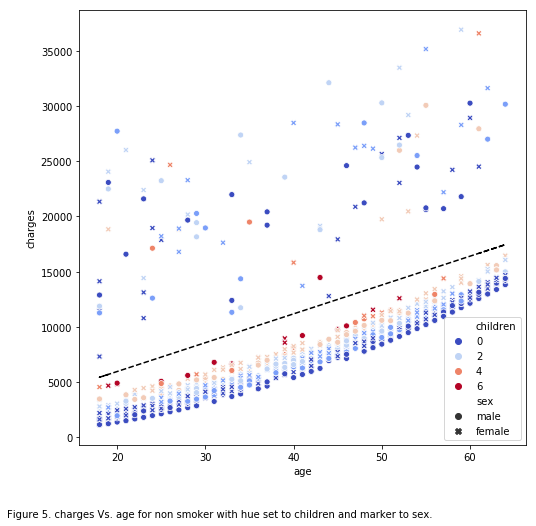

In [36]:
# set up a figure object for Figure 5
fig, ax = plt.subplots(ncols=1,figsize=(8,8))


# Make a plot of charges versus age using seaborn, 
# with hue set to number of children
# and marker set to sex
# Add a legend to define keys
cVage_nosmoker=sns.scatterplot(data=df[(df['smoker']=='no')],x='age',y='charges',hue='children',style='sex',palette='coolwarm',ax=ax)

# Draw a lign seperating groups of data.
df['cutoff']=df['age']*261+-1853+2600
ax.plot(df['age'],df['cutoff'],color='black',linestyle='--')

# add a caption and plot indicators
txt_fig='Figure 5. charges Vs. age for non smoker with hue set to children and marker to sex.  '
fig.text(0,0,txt_fig);

## Machine Learning on Non-Smoker Group
### Preparing Data

Figure 5. shows that none of the factors we have seen so far would in any clear way tell us what puts some people in the group above the dashed line. A plot with the hue set to **region** (not shown) or **bmi** proves just as unhelpful. Since this is the case, we will clean the data by excluding all the points above the black line. Figure 6 shows a plot of the cleaned data.

In [37]:
# Create a data frame with just the non-smokers 
# in the group below the black line in Figure 5.
df['group 1']=np.greater(df['cutoff'],df['charges'])
df_nonsmoker=df[df['smoker']=='no']
df_nonsmoker=df_nonsmoker[df_nonsmoker['group 1']==True]

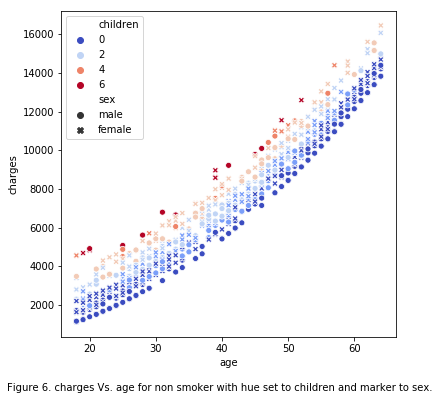

In [38]:

# set up a figure object for Figure 6
fig, ax = plt.subplots(ncols=1,figsize=(6,6))

# Make a plot of charges versus age using seaborn, 
# with hue set to number of children
# and marker set to sex
# Add a legend to define keys
cVage_nosmoker=sns.scatterplot(data=df_nonsmoker,x='age',y='charges',hue='children',style='sex',palette='coolwarm')

# add a caption and plot indicators
txt_fig='Figure 6. charges Vs. age for non smoker with hue set to children and marker to sex.  '
fig.text(0,0,txt_fig);




We can now begin to apply a machine learning algorithm to the cleaned data. For this algorithm to use the parameter of sex I will convert the sex column into two numeric columns for female and male, with either 1 or 0 entries based on the sex of the contractor.

In [39]:
# Create a numerical column for sex 
# (creates a female and male column)
df_nonsmoker[['female','male']]=pd.get_dummies(df_nonsmoker['sex'],drop_first=False)

### Train, Test and Evaluate


We may wish to start with a linear regression as done with the smoker group. However, it does seem from Figure 6. that a higher power dependence on age would be appropriate without taking on an issue of over-fitting. To start we import some libraries for doing a polynomial fit.

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

We now preform a quadratic fit to the data. Figure 7. shows the results of how our predictions match up with our test data, and it seems to have gone quite well. The mean absolute error is MAE=238 and the root mean squared error is RMSE=248 which are each low and close to each other, suggesting we have good accuracy and no major outliers.

MAE: 238.0
RMSE: 248.0


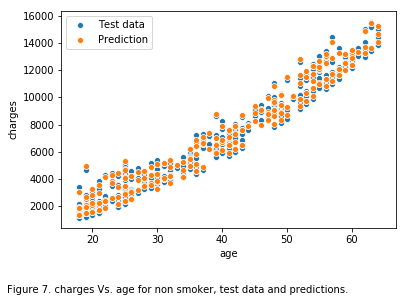

In [41]:
# Create a data frame of features, X_ns, and target values, Y_ns, 
# for non-smoker data.
# Split these into a set of traing data and a set of test data.
X_ns=df_nonsmoker[['age','female','children']]
y_ns=df_nonsmoker['charges']
X_ns_train, X_ns_test, y_ns_train, y_ns_test = train_test_split(X_ns, y_ns, test_size=0.3, random_state=42)

# Create an pipeline instance of a Quadratic and Linear Regression 
# model, train it on our training data 
# and create predictions for test data
model_ns= make_pipeline(PolynomialFeatures(2), LinearRegression())
model_ns.fit(X_ns_train,y_ns_train)
pred_ns = model_ns.predict(X_ns_test)

# Set up a figure object for Figure 7
fig, ax = plt.subplots(ncols=1)
sns.scatterplot(X_ns_test['age'],y_ns_test,ax=ax,label='Test data')
sns.scatterplot(X_ns_test['age'],pred_ns,ax=ax,label='Prediction')

# Add a caption and plot indicators
txt_fig='Figure 7. charges Vs. age for non smoker, test data and predictions.'
fig.text(0,-.1,txt_fig);

# Use metrics to evaluate accuracy of predictions
MAE=metrics.mean_absolute_error(y_ns_test,pred_ns)
MSE=metrics.mean_squared_error(y_ns_test,pred_ns)
RMSE=np.sqrt(metrics.mean_squared_error(y_ns_test,pred_ns))
print('MAE: '+str(round(MAE))+'\nRMSE: '+str(round(RMSE)))

Below we can see the coefficients from our quadratic fit. From the relativity of terms of similar order to one another it does seem that the main factors are **age**^2, **female** and **children**. (a note that **female** and **female** ^2 are the same parameter since the values are 1 r 0, we should really consider this as one parameter for **female** with a coefficient of 2*259=518)

In [43]:
# Create and show data frame with coeffiecnts from our model's fit 
indexc=['intercept','age','female','children','age^2','age*female','age*children','female^2','female*children','children^2']
coef_poly=pd.DataFrame(model_ns.steps[1][1].coef_.transpose(),index=indexc,columns=['Coefficient'])
coef_poly['Coefficient'][0]=model_ns.steps[1][1].intercept_
coef_poly.apply(lambda s:round(s))


,Coefficient
intercept,283.0
age,-1.0
female,259.0
children,604.0
age^2,3.0
age*female,-0.0
age*children,-0.0
female^2,259.0
female*children,-12.0
children^2,0.0


It does seem strange that there would be a linear dependence on **age** for the **smoker** group and a square dependence on **age** for the **non-smoker** group. But it is most likely the case that a square fit would preform just as well on the **smoker** group, and the variance in the **smoker** group is too great for a difference to show. I did in fact perform such an analysis (not shown here) and the MAE and RMSE were very similar to that of our linear fit.

### A Word about Unexplained Data


The analysis presented here seems pretty robust, but we are still left with all that **non-smoker** data we excluded, the data above the back dashed line in Figure 5. I don’t present the work here but I did try to run a few classification models to see what makes those points different, but it was unsuccessful. However, I will note that if one looks at Figure 3. it seems that the mysterious high charged **non-smoker** data is dispersed around the **smoker** with **bmi under 30** data. This may suggest some connection between these two groups. What comes to mind is that the high charged **non-smoker** data is made up of individuals who do not smoke but live with people who do. We are not given this information, but it maybe worthwhile information to try to obtain going forward.